# Waste Classifier PyTorch Model

## Goal
Create a PyTorch model that can distinguish between 6 classes:
- cardboard
- glass
- metal
- paper
- plastic
- trash

## 0 - Setup

In [4]:
import torch
import torchvision

print(torch.__version__) # 1.12+
print(torchvision.__version__) # 0.13+

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

try:
    from scripts import data_setup, engine, utils
    from helper_functions import download_data, set_seeds, plot_loss_curves
    print("Base imports done.")
except:
    print("Couldn't find helper scripts, downloading from Github...")
    !git clone https://github.com/tznpau/waste-classifier
    !mv waste-classifier/scripts .
    !mv waste-classifier/helper_functions.py .
    !rm -rf waste-classifier
    from scripts import data_setup, engine, utils
    from helper_functions import download_data, set_seeds, plot_loss_curves

2.1.1
0.16.1
Base imports done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
torch.cuda.is_available()

True

## 1. Getting data

In [7]:
trash_dataset_path = download_data(source="https://github.com/tznpau/waste-classifier/raw/main/data/trash_dataset.zip",
                                   destination="trash_dataset")
trash_dataset_path

[INFO] data\trash_dataset directory exists, skipping download.


WindowsPath('data/trash_dataset')

In [8]:
# Setup training and test data directories
train_dir = trash_dataset_path / "train"
test_dir = trash_dataset_path / "test"

train_dir, test_dir

(WindowsPath('data/trash_dataset/train'),
 WindowsPath('data/trash_dataset/test'))

## 2. Deployment questions
1. ideal model scenario ?
2. where is the model going to go ?
3. how is the model going to function ?

**ideal use case**
- performs at 90%+ accuracy
- performs fast

## 3. EffNetB2 feature extractor

https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [9]:
effnetb2 = torchvision.models.efficientnet_b2()
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [11]:


# summary(effnetb2,
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
#         verbose=0,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

The last layer of EffNetB2 is called **`classifier`**.

In [12]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [13]:
set_seeds()

effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=6, bias=True)
)

In [14]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=6, bias=True)
)

So after freezing the base layer I adapted the EffNetB2 architecture to suit my use case.

### 3.1 Creating an EffNetB2 feature extractor

In [15]:
def create_effnetb2_model(num_classes:int=6,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    ).to(device)

    return model, transforms

In [16]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=6, seed=42)

In [17]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 DataLoaders for EffNetB2

In [18]:
from scripts import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                  test_dir=test_dir,
                                                                                                  transform=effnetb2_transforms,
                                                                                                  batch_size=32)

Let's check that the split was done correctly during `data_setup.create_dataloaders`.

In [19]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

We have 64 batches for the train dataloader and 16 batches for the test dataloader.

### 3.3 Training EffNetB2 feature extractor

In [56]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

set_seeds(42)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2477 | train_acc: 0.6017 | test_loss: 0.9163 | test_acc: 0.7693
Epoch: 2 | train_loss: 0.8207 | train_acc: 0.7603 | test_loss: 0.7221 | test_acc: 0.7960
Epoch: 3 | train_loss: 0.6892 | train_acc: 0.7852 | test_loss: 0.6375 | test_acc: 0.8072
Epoch: 4 | train_loss: 0.5913 | train_acc: 0.8218 | test_loss: 0.5835 | test_acc: 0.8094
Epoch: 5 | train_loss: 0.5669 | train_acc: 0.8197 | test_loss: 0.5459 | test_acc: 0.8214
Epoch: 6 | train_loss: 0.5118 | train_acc: 0.8332 | test_loss: 0.5216 | test_acc: 0.8253
Epoch: 7 | train_loss: 0.4996 | train_acc: 0.8415 | test_loss: 0.5075 | test_acc: 0.8412
Epoch: 8 | train_loss: 0.4759 | train_acc: 0.8387 | test_loss: 0.4916 | test_acc: 0.8281
Epoch: 9 | train_loss: 0.4379 | train_acc: 0.8628 | test_loss: 0.4775 | test_acc: 0.8331
Epoch: 10 | train_loss: 0.4305 | train_acc: 0.8590 | test_loss: 0.4671 | test_acc: 0.8404


### 3.4 Analysing EffNetB2 loss curves

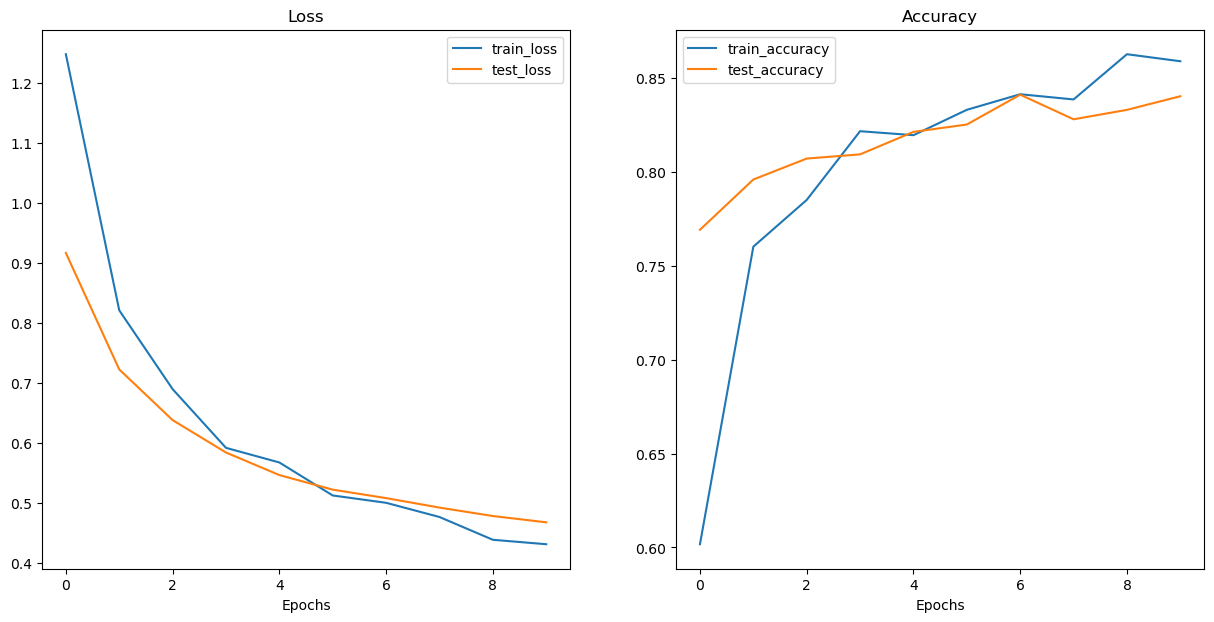

In [57]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

Overall, the issue with the `effnetb2` model is the fact that it's **not** able to break the 90% accuracy barrier that we've set as a goal in the beginning. 

During the first and the last few epochs it is also showing a **tendency to overfit**.

On my cuda enabled device, it trained in 15:49 minutes.

### 3.5 Saving EffNetB2 feature extractor

In [58]:
from scripts import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_model_v0_waste_classifier.pth")

Saving model to: models\effnetb2_model_v0_waste_classifier.pth


### 3.6 Collecting stats on EffNetB2

In [59]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/effnetb2_model_v0_waste_classifier.pth").stat().st_size // (1024*1024)
print(f"Size of pretrained EffNetB2 feature extractor: {pretrained_effnetb2_model_size} MB.")

Size of pretrained EffNetB2 feature extractor: 29 MB.


In [60]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7709448

In [61]:
effnetb2_stats = {
    "test_loss" : effnetb2_results["test_loss"][-1],
    "test_acc" : effnetb2_results["test_acc"][-1],
    "total_number_of_parameters" : effnetb2_total_params,
    "model_size (MB)" : pretrained_effnetb2_model_size
}

effnetb2_stats

{'test_loss': 0.46707860473543406,
 'test_acc': 0.8404017857142857,
 'total_number_of_parameters': 7709448,
 'model_size (MB)': 29}

## 4. ViT feature extractor

https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights

In [22]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

The last layer of ViT_b_16 is called **`heads`**.

### 4.1 Creating a ViT feature extractor

In [23]:
def create_vit_model(num_classes:int=6,
                     seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes)
    )

    return model, transforms

In [24]:
vit, vit_transforms = create_vit_model()

In [25]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 6]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.2 Creating DataLoaders for ViT

In [27]:
from scripts import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                  test_dir=test_dir,
                                                                                                  transform=vit_transforms,
                                                                                                  batch_size=32)

In [28]:
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

### 4.3 Training ViT feature extractor

In [62]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

set_seeds()

vit_results = engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8420 | train_acc: 0.7194 | test_loss: 0.5528 | test_acc: 0.8421
Epoch: 2 | train_loss: 0.4357 | train_acc: 0.8630 | test_loss: 0.4550 | test_acc: 0.8541
Epoch: 3 | train_loss: 0.3402 | train_acc: 0.8970 | test_loss: 0.4148 | test_acc: 0.8717
Epoch: 4 | train_loss: 0.2842 | train_acc: 0.9141 | test_loss: 0.3924 | test_acc: 0.8733
Epoch: 5 | train_loss: 0.2432 | train_acc: 0.9263 | test_loss: 0.3736 | test_acc: 0.8756
Epoch: 6 | train_loss: 0.2150 | train_acc: 0.9414 | test_loss: 0.3680 | test_acc: 0.8717
Epoch: 7 | train_loss: 0.1885 | train_acc: 0.9497 | test_loss: 0.3549 | test_acc: 0.8758
Epoch: 8 | train_loss: 0.1745 | train_acc: 0.9572 | test_loss: 0.3548 | test_acc: 0.8795
Epoch: 9 | train_loss: 0.1561 | train_acc: 0.9624 | test_loss: 0.3512 | test_acc: 0.8778
Epoch: 10 | train_loss: 0.1386 | train_acc: 0.9717 | test_loss: 0.3442 | test_acc: 0.8820


### 4.4 Analysing ViT loss curves

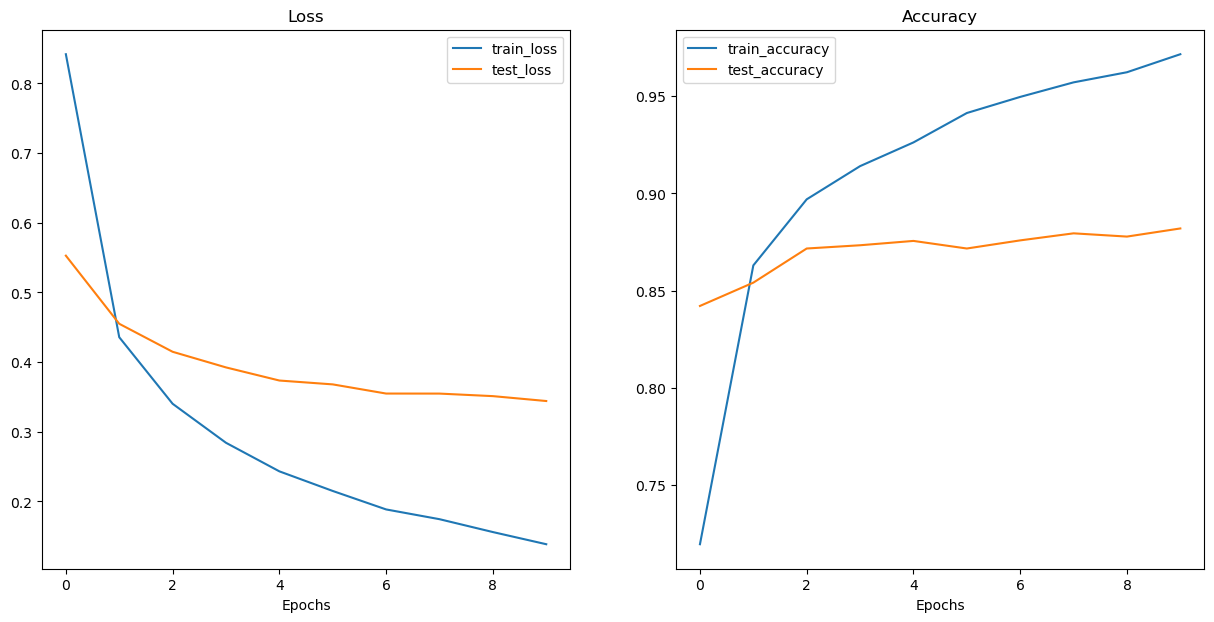

In [63]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

The `vit` model suffers from **overfitting**, and, although it achieves higher accuracy than the previous `effnetb2`, it still cannot pass the threshold of 90% accuracy.

On my cuda enabled device, it trained in 29:34 minutes, almost twice as long as the previous feature extractor.

### 4.5 Saving ViT feature extractor

In [64]:
from scripts import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit_model_v0_waste_classifier.pth")

Saving model to: models\vit_model_v0_waste_classifier.pth


### 4.6 Collecting stats on ViT

In [65]:
from pathlib import Path

pretrained_vit_model_size = Path("models/vit_model_v0_waste_classifier.pth").stat().st_size // (1024*1024)
print(f"Size of pretrained ViT feature extractor: {pretrained_vit_model_size} MB.")

Size of pretrained ViT feature extractor: 327 MB.


In [66]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85803270

In [67]:
vit_stats = {
    "test_loss" : vit_results["test_loss"][-1],
    "test_acc" : vit_results["test_acc"][-1],
    "total_number_of_parameters" : vit_total_params,
    "model_size (MB)" : pretrained_vit_model_size
}

vit_stats

{'test_loss': 0.34415431320667267,
 'test_acc': 0.8819754464285714,
 'total_number_of_parameters': 85803270,
 'model_size (MB)': 327}

## 5. ResNet50 feature extractor

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [30]:
resnet50 = torchvision.models.resnet50()
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The last layer of ResNet50 is called **`fc`**.

### 5.1 Creating a ResNet50 feature extractor

In [31]:
def create_resnet50_model(num_classes:int=6,
                          seed:int=42):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.fc = nn.Linear(in_features=2048, out_features=num_classes).to(device)

    return model, transforms

In [32]:
resnet50, resnet50_transforms = create_resnet50_model(num_classes=6, seed=42)

In [33]:
resnet50.fc

Linear(in_features=2048, out_features=6, bias=True)

In [34]:
resnet50_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 5.2 DataLoaders for ResNet50

In [35]:
from scripts import data_setup

train_dataloader_resnet50, test_dataloader_resnet50, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=resnet50_transforms,
                                                                                                 batch_size=32)

Let's check that the split was done correctly during `data_setup.create_dataloaders`.

In [37]:
len(train_dataloader_resnet50), len(test_dataloader_resnet50), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

We have 64 batches of ~32 images for the train dataloader and 16 batches of ~32 images for the test dataloader.

### 5.3 Training ResNet50 feature extractor

In [38]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(),
                             lr=1e-3)

set_seeds(42)

resnet50_results = engine.train(model=resnet50,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1592 | train_acc: 0.6211 | test_loss: 0.8210 | test_acc: 0.7888
Epoch: 2 | train_loss: 0.7156 | train_acc: 0.7962 | test_loss: 0.6473 | test_acc: 0.8398
Epoch: 3 | train_loss: 0.5780 | train_acc: 0.8338 | test_loss: 0.5547 | test_acc: 0.8493
Epoch: 4 | train_loss: 0.4689 | train_acc: 0.8730 | test_loss: 0.5176 | test_acc: 0.8591
Epoch: 5 | train_loss: 0.4176 | train_acc: 0.8965 | test_loss: 0.4680 | test_acc: 0.8750
Epoch: 6 | train_loss: 0.3734 | train_acc: 0.9010 | test_loss: 0.4310 | test_acc: 0.8775
Epoch: 7 | train_loss: 0.3392 | train_acc: 0.9092 | test_loss: 0.4226 | test_acc: 0.8859
Epoch: 8 | train_loss: 0.3111 | train_acc: 0.9128 | test_loss: 0.3951 | test_acc: 0.8881
Epoch: 9 | train_loss: 0.2860 | train_acc: 0.9365 | test_loss: 0.3900 | test_acc: 0.8917
Epoch: 10 | train_loss: 0.2632 | train_acc: 0.9411 | test_loss: 0.3662 | test_acc: 0.9040


On my cuda enabled device, it trained through 10 epochs in 17:24 minutes.

In [40]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(),
                             lr=1e-3)

resnet50_results = engine.train(model=resnet50,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                epochs=20,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2481 | train_acc: 0.9424 | test_loss: 0.3760 | test_acc: 0.8783
Epoch: 2 | train_loss: 0.2370 | train_acc: 0.9310 | test_loss: 0.3607 | test_acc: 0.8923
Epoch: 3 | train_loss: 0.2002 | train_acc: 0.9570 | test_loss: 0.3570 | test_acc: 0.9057
Epoch: 4 | train_loss: 0.1870 | train_acc: 0.9619 | test_loss: 0.3577 | test_acc: 0.9015
Epoch: 5 | train_loss: 0.2001 | train_acc: 0.9559 | test_loss: 0.3442 | test_acc: 0.8934
Epoch: 6 | train_loss: 0.1709 | train_acc: 0.9587 | test_loss: 0.3274 | test_acc: 0.9138
Epoch: 7 | train_loss: 0.1693 | train_acc: 0.9631 | test_loss: 0.3205 | test_acc: 0.9074
Epoch: 8 | train_loss: 0.1447 | train_acc: 0.9771 | test_loss: 0.3310 | test_acc: 0.9138
Epoch: 9 | train_loss: 0.1609 | train_acc: 0.9657 | test_loss: 0.3140 | test_acc: 0.9104
Epoch: 10 | train_loss: 0.1364 | train_acc: 0.9736 | test_loss: 0.3105 | test_acc: 0.9196
Epoch: 11 | train_loss: 0.1343 | train_acc: 0.9743 | test_loss: 0.3206 | test_acc: 0.9099
Epoch: 12 | train_l

### 5.4 Analysing ResNet50 loss curves

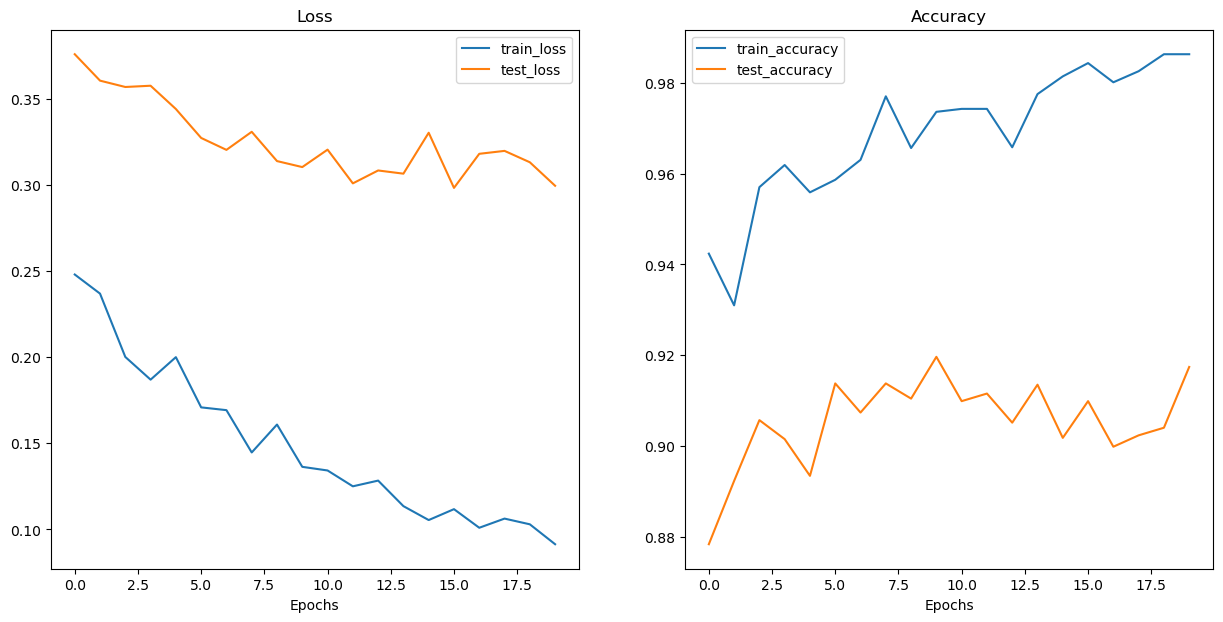

In [41]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results)

Issue: the `resnet50` model is **overfitting**.
- model is learning the data well
- *but* the patterns it's learning don't generalize that well on the test data
- notably, the test accuracy still broke 90%

Here are things we could try in the future in order to try to achieve an even **better performance**:

- Increase dataset size (get more data, or better data) -> a great way to do this would be *data augmentation* - https://pytorch.org/vision/main/transforms.html
- Add a *`Dropout`* layer before the output layer - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
- Use learning rate decay - PyTorch learning rate scheduler - https://pytorch.org/docs/stable/optim.html

### 5.5 Saving ResNet50 feature extractor

In [42]:
from scripts import utils

utils.save_model(model=resnet50,
                 target_dir="models",
                 model_name="resnet50_model_v1_waste_classifier.pth")

Saving model to: models\resnet50_model_v1_waste_classifier.pth


### 5.6 Collecting stats on ResNet50

#### Model size

`pathlib.Path("path_to_model").stat().st_size()` - checks the model's size in *bytes*.

` // (1024*1024)` - division to roughly convert the size to *megabytes* and round it up by 2 decimals.

In [44]:
from pathlib import Path

pretrained_resnet50_model_size = Path("models/resnet50_model_v1_waste_classifier.pth").stat().st_size // (1024*1024)
print(f"Size of pretrained ResNet50 feature extractor: {pretrained_resnet50_model_size} MB.")

Size of pretrained ResNet50 feature extractor: 90 MB.


#### Total number of parameters

In [43]:
resnet50_total_params = sum(torch.numel(param) for param in resnet50.parameters())
resnet50_total_params

23520326

A higher number of parameters means the model has a higher capacity to learn.

However, a larger capacity often comes with an increased model filesize and a longer time to perform inference.

In [45]:
resnet50_stats = {
    "test_loss" : resnet50_results["test_loss"][-1],
    "test_acc" : resnet50_results["test_acc"][-1],
    "total_number_of_parameters" : resnet50_total_params,
    "model_size (MB)" : pretrained_resnet50_model_size
}

resnet50_stats

{'test_loss': 0.2996218018233776,
 'test_acc': 0.9174107142857143,
 'total_number_of_parameters': 23520326,
 'model_size (MB)': 90}

## 6. Making predictions

In [46]:
from pathlib import Path

print(f"Finding all files ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

Finding all files ending with '.jpg' in directory: data\trash_dataset\test


[WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard11.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard110.jpg'),
 WindowsPath('data/trash_dataset/test/cardboard/cardboard117.jpg')]

### 6.1 Function `pred_and_store()` to make predictions across the dataset

In [55]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> List[Dict]:

    """
    Returns a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time.
    """
    pred_list = []
    for path in tqdm(paths):
        pred_dict = {}
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)
        transformed_image = transform(img).unsqueeze(0).to(device)
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image) # inference on target image
            pred_prob = torch.softmax(pred_logit, dim=1) # logits -> pred probs
            pred_label = torch.argmax(pred_prob, dim=1) # pred probs -> pred labels
            pred_class = class_names[pred_label.cpu()] # hardcode prediction classes to be on cpu

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4) # dictionaries have to be on cpu for inspecting preds later on
            pred_dict["pred_class"] = pred_class

            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)

    return pred_list

### 6.2 Making and timing predictions with ResNet50

In [48]:
resnet50_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=resnet50,
                                          transform=resnet50_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/508 [00:00<?, ?it/s]

In [49]:
resnet50_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9994,
  'pred_class': 'cardboard',
  'time_for_pred': 0.3224,
  'correct': True},
 {'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9959,
  'pred_class': 'cardboard',
  'time_for_pred': 0.0675,
  'correct': True}]

In [50]:
import pandas as pd
resnet50_test_pred_df = pd.DataFrame(resnet50_test_pred_dicts)
resnet50_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\trash_dataset\test\cardboard\cardboard103...,cardboard,0.9994,cardboard,0.3224,True
1,data\trash_dataset\test\cardboard\cardboard104...,cardboard,0.9959,cardboard,0.0675,True
2,data\trash_dataset\test\cardboard\cardboard11.jpg,cardboard,0.9985,cardboard,0.0625,True
3,data\trash_dataset\test\cardboard\cardboard110...,cardboard,0.9867,cardboard,0.0651,True
4,data\trash_dataset\test\cardboard\cardboard117...,cardboard,0.7790,cardboard,0.0623,True


**How many predictions** did the `resnet50` model get **wrong** ?

In [51]:
resnet50_test_pred_df.correct.value_counts()

correct
True     467
False     41
Name: count, dtype: int64

What was the **average prediction time** ?

In [52]:
resnet50_average_time_per_pred = round(resnet50_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {resnet50_average_time_per_pred} seconds")

Average time per prediction: 0.0644 seconds


In [53]:
resnet50_stats["time_per_pred_cpu"] = resnet50_average_time_per_pred
resnet50_stats

{'test_loss': 0.2996218018233776,
 'test_acc': 0.9174107142857143,
 'total_number_of_parameters': 23520326,
 'model_size (MB)': 90,
 'time_per_pred_cpu': 0.0644}

### 6.3 Making and timing predictions with EffNetB2

In [68]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/508 [00:00<?, ?it/s]

In [69]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9735,
  'pred_class': 'cardboard',
  'time_for_pred': 0.8187,
  'correct': True},
 {'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.9729,
  'pred_class': 'cardboard',
  'time_for_pred': 0.112,
  'correct': True}]

In [70]:
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\trash_dataset\test\cardboard\cardboard103...,cardboard,0.9735,cardboard,0.8187,True
1,data\trash_dataset\test\cardboard\cardboard104...,cardboard,0.9729,cardboard,0.1120,True
2,data\trash_dataset\test\cardboard\cardboard11.jpg,cardboard,0.9963,cardboard,0.1107,True
3,data\trash_dataset\test\cardboard\cardboard110...,cardboard,0.9110,cardboard,0.1088,True
4,data\trash_dataset\test\cardboard\cardboard117...,cardboard,0.9450,cardboard,0.1068,True


In [71]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     428
False     80
Name: count, dtype: int64

In [72]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {effnetb2_average_time_per_pred} seconds")

Average time per prediction: 0.0791 seconds


In [73]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.46707860473543406,
 'test_acc': 0.8404017857142857,
 'total_number_of_parameters': 7709448,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0791}

### 6.4 Making and timing predictions with ViT

In [74]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/508 [00:00<?, ?it/s]

In [75]:
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard103.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.999,
  'pred_class': 'cardboard',
  'time_for_pred': 1.0978,
  'correct': True},
 {'image_path': WindowsPath('data/trash_dataset/test/cardboard/cardboard104.jpg'),
  'class_name': 'cardboard',
  'pred_prob': 0.4435,
  'pred_class': 'trash',
  'time_for_pred': 0.4651,
  'correct': False}]

In [76]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\trash_dataset\test\cardboard\cardboard103...,cardboard,0.9990,cardboard,1.0978,True
1,data\trash_dataset\test\cardboard\cardboard104...,cardboard,0.4435,trash,0.4651,False
2,data\trash_dataset\test\cardboard\cardboard11.jpg,cardboard,0.9998,cardboard,0.4621,True
3,data\trash_dataset\test\cardboard\cardboard110...,cardboard,0.9463,cardboard,0.4675,True
4,data\trash_dataset\test\cardboard\cardboard117...,cardboard,0.5975,cardboard,0.4372,True


In [77]:
vit_test_pred_df.correct.value_counts()

correct
True     449
False     59
Name: count, dtype: int64

In [78]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"Average time per prediction: {vit_average_time_per_pred} seconds")

Average time per prediction: 0.3374 seconds


In [79]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.34415431320667267,
 'test_acc': 0.8819754464285714,
 'total_number_of_parameters': 85803270,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.3374}

## 7. Comparing model results, prediction times and sizes

In [80]:
df = pd.DataFrame([effnetb2_stats, vit_stats, resnet50_stats])
df["model"] = ["EffNetB2", "ViT", "ResNet50"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,total_number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.467079,84.04,7709448,29,0.0791,EffNetB2
1,0.344154,88.20,85803270,327,0.3374,ViT
2,0.299622,91.74,23520326,90,0.0644,ResNet50


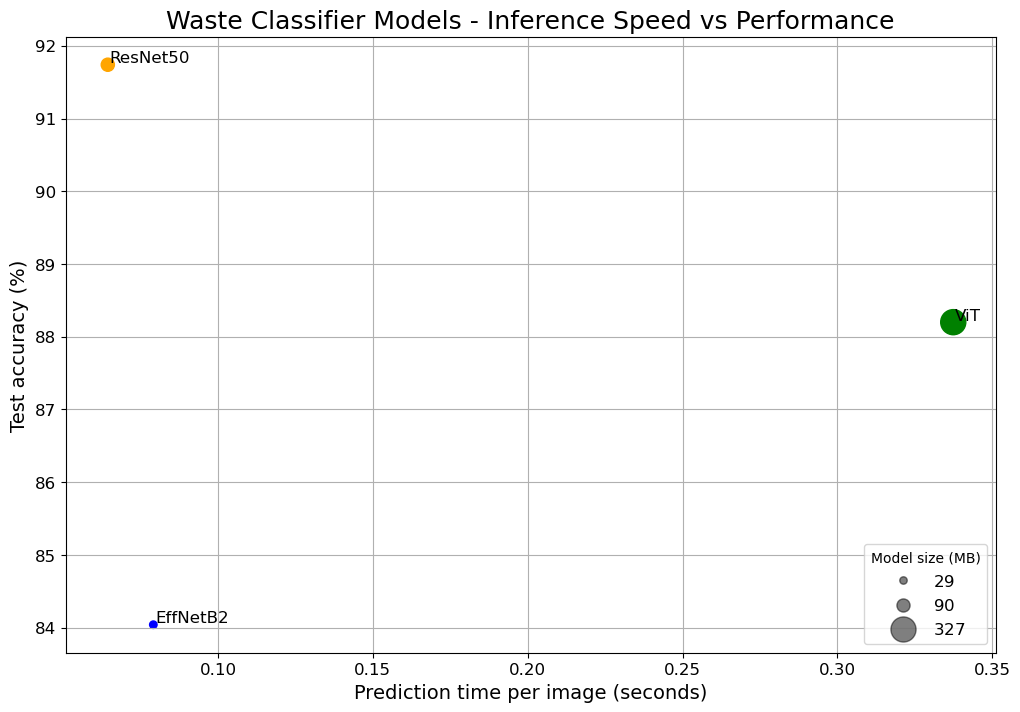

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "green", "orange"],
                     s="model_size (MB)") # size the dots by the model sizes

ax.set_title("Waste Classifier Models - Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"], 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

plt.savefig("waste-classifier-models-inference-speed-vs-performance.jpg")
plt.show()

Main takeaways from this visualization:
- `effnetb2` is the smallest model at 29 MB
- `vit` is the biggest model at 327 MB, as well as the slowest, with an accuracy in between the other two
- `resnet50` is the fastest model at inference, and has a decent size of 90 MB